# Решение домашнего задания #7

In [15]:
import kagglehub

import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.transforms.functional import to_tensor
from PIL import Image

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

from Image2Text import Config as ModelConfig, Encoder, DecoderWithAttention

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
TARGET_SIZE = 300

# Загружаем данные

In [4]:
path = kagglehub.dataset_download("adityajn105/flickr8k")

data = pd.read_csv(path + "/captions.txt")
data["image"] = data["image"].apply(
    lambda t: f"{path}/Images/{t}"
)

data = data.sample(frac=1).reset_index(drop=True)
data

image  \
0      C:\Users\setday\.cache\kagglehub\datasets\adit...   
1      C:\Users\setday\.cache\kagglehub\datasets\adit...   
2      C:\Users\setday\.cache\kagglehub\datasets\adit...   
3      C:\Users\setday\.cache\kagglehub\datasets\adit...   
4      C:\Users\setday\.cache\kagglehub\datasets\adit...   
...                                                  ...   
40450  C:\Users\setday\.cache\kagglehub\datasets\adit...   
40451  C:\Users\setday\.cache\kagglehub\datasets\adit...   
40452  C:\Users\setday\.cache\kagglehub\datasets\adit...   
40453  C:\Users\setday\.cache\kagglehub\datasets\adit...   
40454  C:\Users\setday\.cache\kagglehub\datasets\adit...   

                                                 caption  
0      Two boys are swimming underwater in a pool and...  
1      There is a black dog jumping into a swimming p...  
2      A group of children are playing with bubbles o...  
3      Girl regains composure in a sunset with a man ...  
4      A woman in a kayak with dog rests her paddle o...  
...                                                  ...  
40450  Three happy boys wearing blue bathing suits ho...  
40451        Young girl with blue eyes eating a cookie .  
40452  The four children are running to a brick build...  
40453  A little boy is swinging on a swing beside som...  
40454                    A black dog jumps in the snow .  

[40455 rows x 2 columns]

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
tokenizer.add_special_tokens({'pad_token': '<|end|>'})

1

In [6]:
class CustomLoader(DataLoader):
    def __init__(self, data, batch_size=16, shuffle=True):
        super().__init__(data, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True, persistent_workers=True)

        self.tokens = tokenizer(
            data["caption"].tolist(),
            padding=True,
            return_tensors="pt"
        )["input_ids"]
        self.lenths = self.tokens.ne(tokenizer.pad_token_id).sum(dim=1)
        self.images = data["image"]

    def __iter__(self):
        for i in range(0, len(self.tokens), self.batch_size):
            yield (
                torch.stack([
                    to_tensor(Image.open(image_name).resize((TARGET_SIZE, TARGET_SIZE)))
                    for image_name in self.images.iloc[i:i + self.batch_size]
                ]),
                self.tokens[i:i + self.batch_size],
                self.lenths[i:i + self.batch_size]
            )

    def __len__(self):
        return len(self.tokens) // self.batch_size

In [7]:
train_dl = CustomLoader(data.iloc[:5000])
test_dl = CustomLoader(data.iloc[5000:6000], shuffle=False)

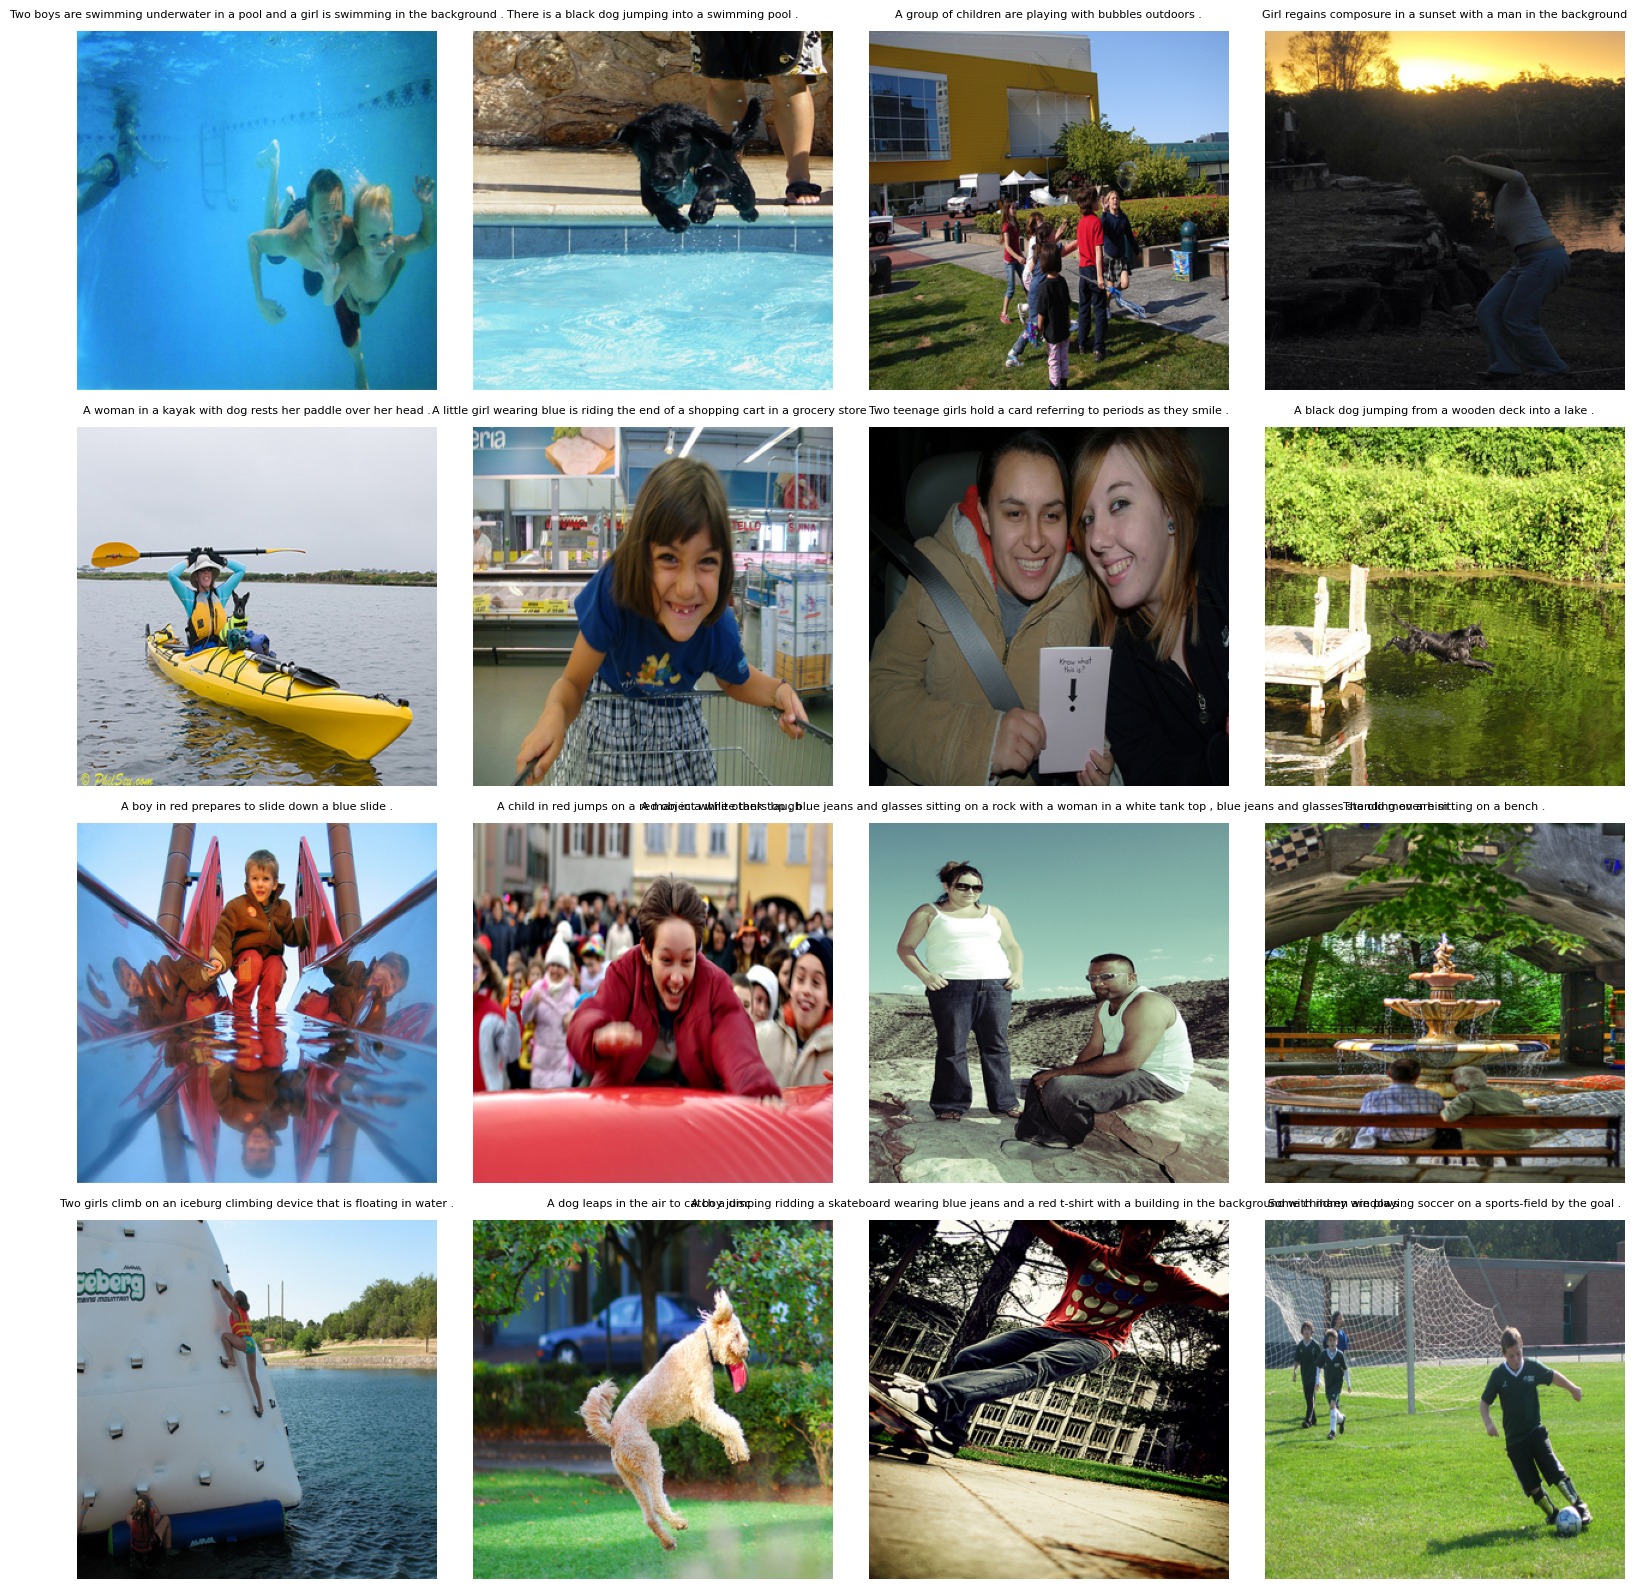

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i, (images, tokens, lenths) in enumerate(train_dl):
    if i == 0:
        for j in range(4):
            for k in range(4):
                ax[j, k].imshow(images[j * 4 + k].permute(1, 2, 0))
                ax[j, k].set_title(tokenizer.decode(tokens[j * 4 + k], skip_special_tokens=True), fontsize=8, pad=10)
                ax[j, k].axis('off')
        break
plt.tight_layout()

# Создаем модельку

In [17]:
config = ModelConfig()

In [18]:
class CombinedModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = DecoderWithAttention(config)

    def forward(self, images, sequences, lengths):
        features = self.encoder(images)
        return self.decoder(features, sequences, lengths)

class LightningModel(LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = CombinedModel(config)

        self.loss = nn.CrossEntropyLoss(
            ignore_index=tokenizer.pad_token_id,
            label_smoothing=0.1
        )

        self.loss_history = []
        self.val_loss_history = []

    def forward(self, images, sequences, lengths):
        return self.model(images, sequences, lengths)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        images, sequences, lengths = batch

        scores, caps_sorted, decode_lengths, _, _ = self.forward(
            images,
            sequences,
            lengths
        )
        targets = caps_sorted[:, 1:]
        
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss = self.loss(scores, targets)

        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)

        self.loss_history.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, sequences, lengths = batch

        scores, caps_sorted, decode_lengths, alphas, sort_ind = self.forward(
            images,
            sequences,
            lengths
        )
        targets = caps_sorted[:, 1:]

        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        loss = self.loss(scores, targets)

        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)

        self.val_loss_history.append(loss.item())
        return loss

In [19]:
model = LightningModel(config)

# Обучаем модельку

In [20]:
trainer = Trainer(
    max_epochs=6,
    accelerator="auto",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CombinedModel    | 73.1 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
72.9 M    Trainable params
225 K     Non-trainable params
73.1 M    Total params
292.382   Total estimated model params size (MB)
304       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


<Axes: >

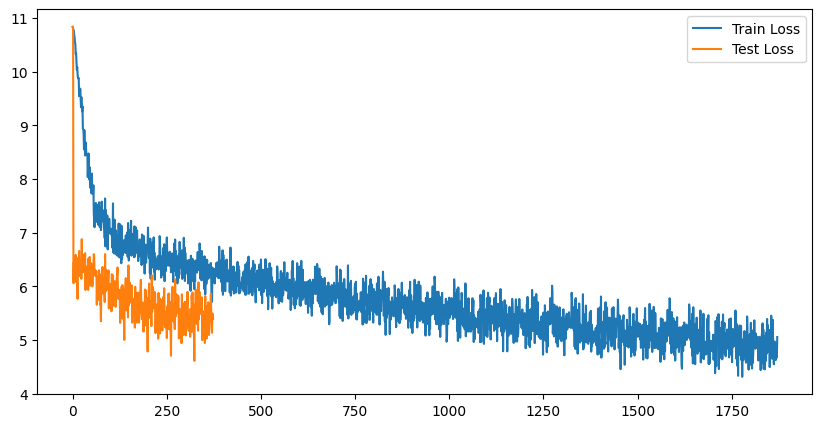

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Train Loss')
sns.lineplot(x=range(len(model.val_loss_history)), y=model.val_loss_history, label='Test Loss')

# Инферем

In [53]:
def generate_caption(model, image, tokenizer, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.model.encoder(image.unsqueeze(0))
        sequences = torch.tensor([[tokenizer.bos_token_id]], device=image.device)
        lengths = torch.tensor([2], device=image.device)

        for _ in range(max_length):
            scores, _, _, _, _ = model.model.decoder(features, sequences, lengths)
            scores = scores[:, -1, :]
            predicted = scores.argmax(dim=1).unsqueeze(1)

            if predicted.item() == tokenizer.eos_token_id:
                break

            sequences = torch.cat([sequences, predicted], dim=1)
            lengths += 1

        caption = tokenizer.decode(sequences[0], skip_special_tokens=True)
    return caption

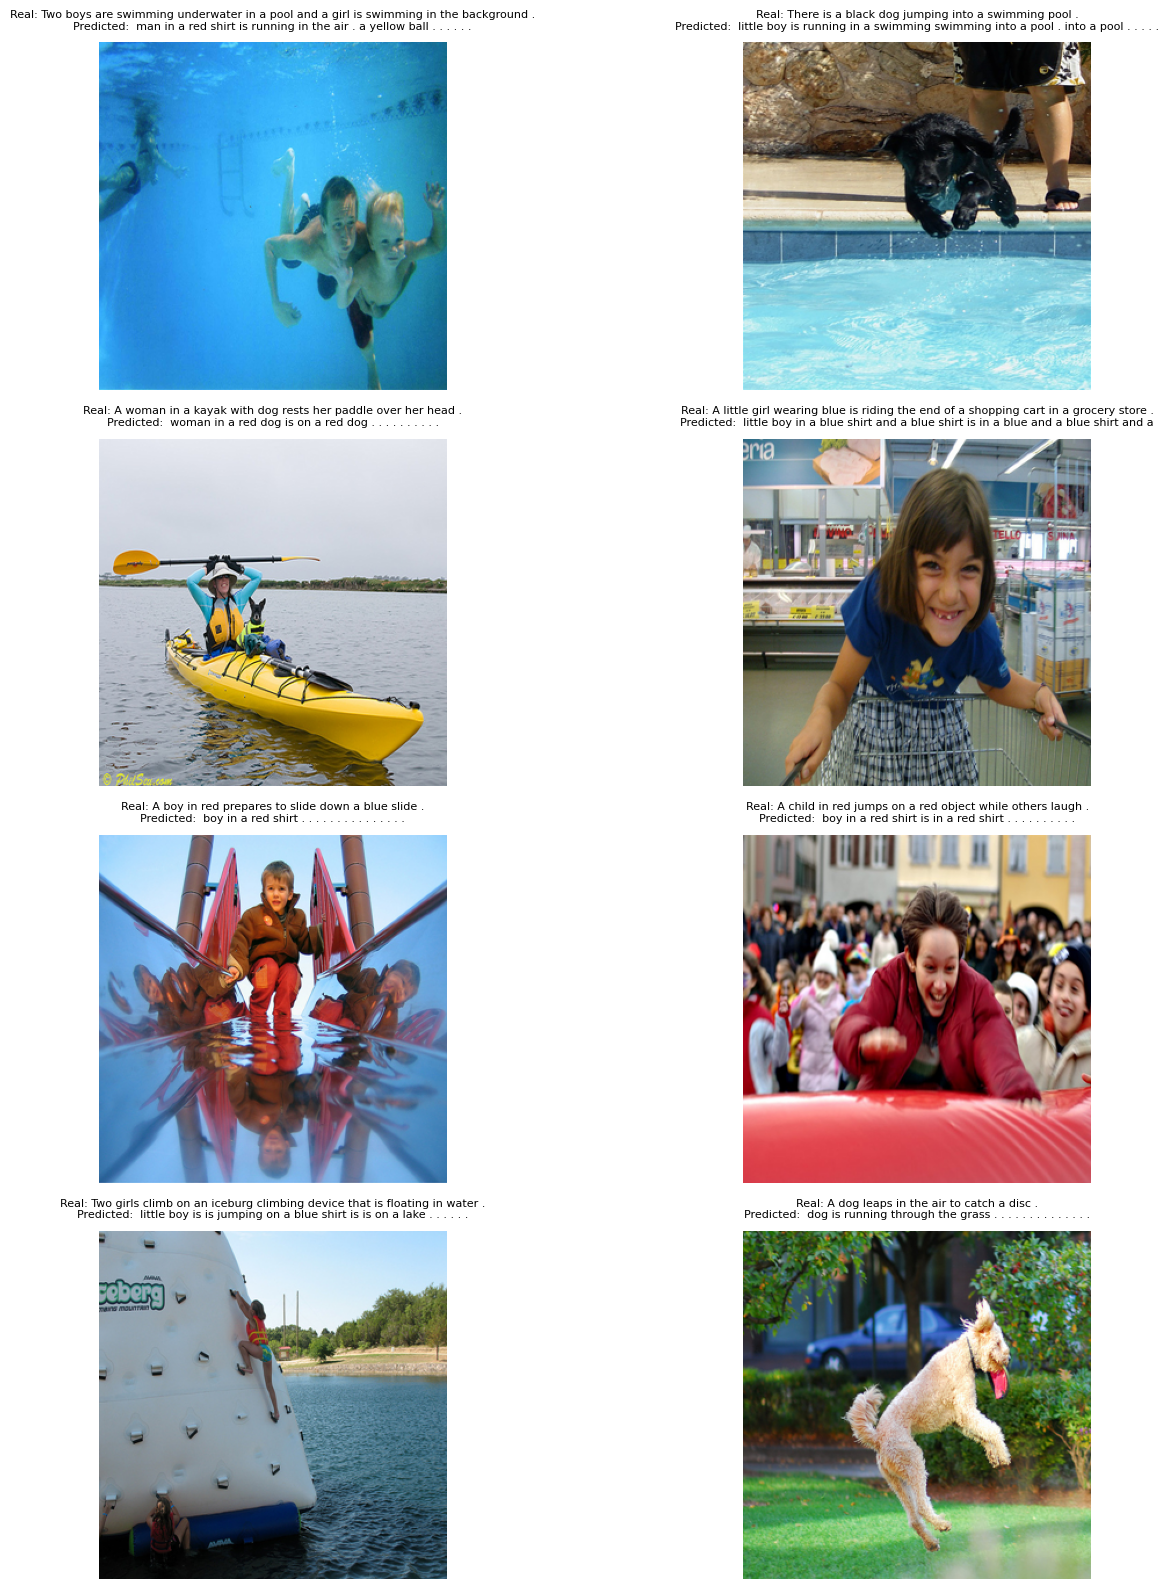

In [55]:
fig, ax = plt.subplots(4, 2, figsize=(16, 16))
for i, (images, tokens, lenths) in enumerate(train_dl):
    if i == 0:
        for j in range(4):
            for k in range(2):
                real_text = tokenizer.decode(tokens[j * 4 + k], skip_special_tokens=True)
                pred_text = generate_caption(model, images[j * 4 + k], tokenizer)

                caption = f"Real: {real_text}\nPredicted: {pred_text}"

                ax[j, k].imshow(images[j * 4 + k].permute(1, 2, 0))
                ax[j, k].set_title(caption, fontsize=8, pad=10)
                ax[j, k].axis('off')
        break
plt.tight_layout()

## Выводы:

Результат получился далеким от идеала (скорее всего это связано с количеством эпох (видно, что обучение можно было продолжить и получить меньший лосс) и данных (больше данных не влезало в оперативку)), однако стоит отметить, что модель уже начала угадывать наличие некоторых объектов на картинке (хотя иногда и путает собак с людьми, и совсем не разбирается в цветах).
